In [31]:
import pandas as pd
import numpy as np
from nltk import FreqDist
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

%matplotlib inline

In [67]:
np.random.randint(0,5)

2

In [ ]:
p

In [2]:
df = pd.read_csv(r'2019politicostweeter.csv',parse_dates=['fecha'])

We apply all the transformations and tokenizations requiered in order to work with the data

In [3]:
wt = RegexpTokenizer('[\w]+')
df['tweets'] =df['tweets'].apply(lambda x: x.lower())
df['tw'] = df['tweets'].apply(lambda x: wt.tokenize(x))
badwords=stopwords.words('spanish')
morebw = ['https','t','co','En','vivo','rt','sé']
for x in morebw:
    badwords.append(x)
df['tw'] = df['tw'].apply(lambda x: [word for word in x if word not in badwords])
df['tws']=df['tw'].apply(lambda x: ' '.join(x))
df['target'] = df['corriente'].map({'peronista':0,'pro':1})
df=df.drop_duplicates('tws').reset_index(drop=True)

In [4]:
df.shape

(6487, 7)

In [5]:
df.head()

,tweets,fecha,twitter,corriente,tw,tws,target
0,sé que por estas horas hay mucha ansiedad polí...,2019-05-23 22:15:03,danielscioli,peronista,"[horas, mucha, ansiedad, política, mediática, ...",horas mucha ansiedad política mediática compre...,0
1,#diamundialdelsindromededown\r\r\r\r\r\r\r\r\r...,2019-03-21 20:37:21,RLavagna,peronista,"[diamundialdelsindromededown, derechos, vida, ...",diamundialdelsindromededown derechos vida dign...,0
2,"esto no es una utopía, es lo que estamos hacie...",2019-07-13 15:49:05,mariuvidal,pro,"[utopía, haciendo, tres, meses, dejar, nunca, ...",utopía haciendo tres meses dejar nunca proyect...,1
3,el sistema de desagües cloacales de la ciudad ...,2019-08-21 11:41:01,frigeriorogelio,pro,"[sistema, desagües, cloacales, ciudad, formosa...",sistema desagües cloacales ciudad formosa anti...,1
4,mejor rascar la urna que el fondo de la olla p...,2019-09-15 01:37:09,FerIglesias,pro,"[mejor, rascar, urna, fondo, olla, ver, si, li...",mejor rascar urna fondo olla ver si ligás carg...,1


In [6]:
def get_freq(df,twitter,column='twitter',nfreq=50):#returns the most frequent terms used by the target twitter account or political afilation
    frequ = df.loc[df[column]==twitter,'tw'].tolist()
    frequ = [item for sublist in frequ for item in sublist]
    return FreqDist(frequ).most_common()[:nfreq]
    

The funcitions below it calculates the similarity(using cosine similary) between each tweet of a certein account versus every other tweet from the rest. For every tweet that surparses a given tolerance it adds it up and returns a bar plot with the results

In [93]:
def simil(df,twitter,tol=0.10):
    pallets = ['dark','coolwarm','deep','hls','husl']
    dic=defaultdict(int)
    user = df.loc[df['twitter']==twitter].reset_index(drop=True)
    rest = df.loc[df['twitter']!=twitter].reset_index(drop=True)
    vectorizer = TfidfVectorizer()
    restM = vectorizer.fit_transform(rest['tws'])
    userM = vectorizer.transform(user['tws'])
    for i in range(userM.shape[0]):
        imil=cosine_similarity(userM[i], restM)
        idx = np.argwhere((imil>tol)&(imil<1))
        if idx.any():
            for x in idx:
                dic[rest['twitter'][x[1]]] += 1
    plt.figure(figsize=(25,10))
    plt.title(f'{twitter} Similarity', weight='bold').set_fontsize('18')
    sns.set_context('poster')
    plt.xlabel('Twitter',weight = 'bold')
    sns.barplot(x=list(dic.keys()),y=list(dic.values()),palette=pallets[np.random.randint(0,4)])
    plt.xticks(rotation=45)

# Frequency Macri and Fernandez 

In [26]:
MM=pd.DataFrame(get_freq(df,'mauriciomacri',nfreq=25),columns=['Term','Freq'])

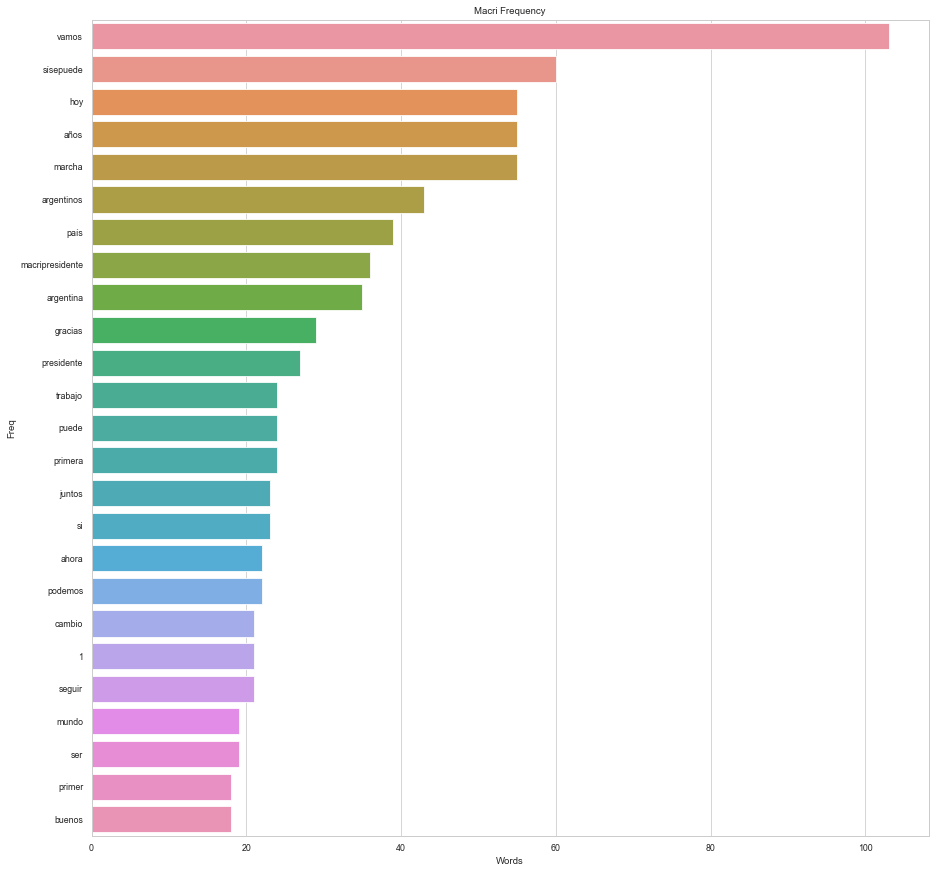

In [27]:
plt.figure(figsize=(15,15))
plt.title('Macri Frequency')
sns.barplot(x=MM['Freq'],y=MM['Term'])
plt.xlabel('Words')
plt.ylabel('Freq')
plt.show()


In [28]:
AF=pd.DataFrame(get_freq(df,'alferdez',nfreq=25),columns=['Term','Freq'])

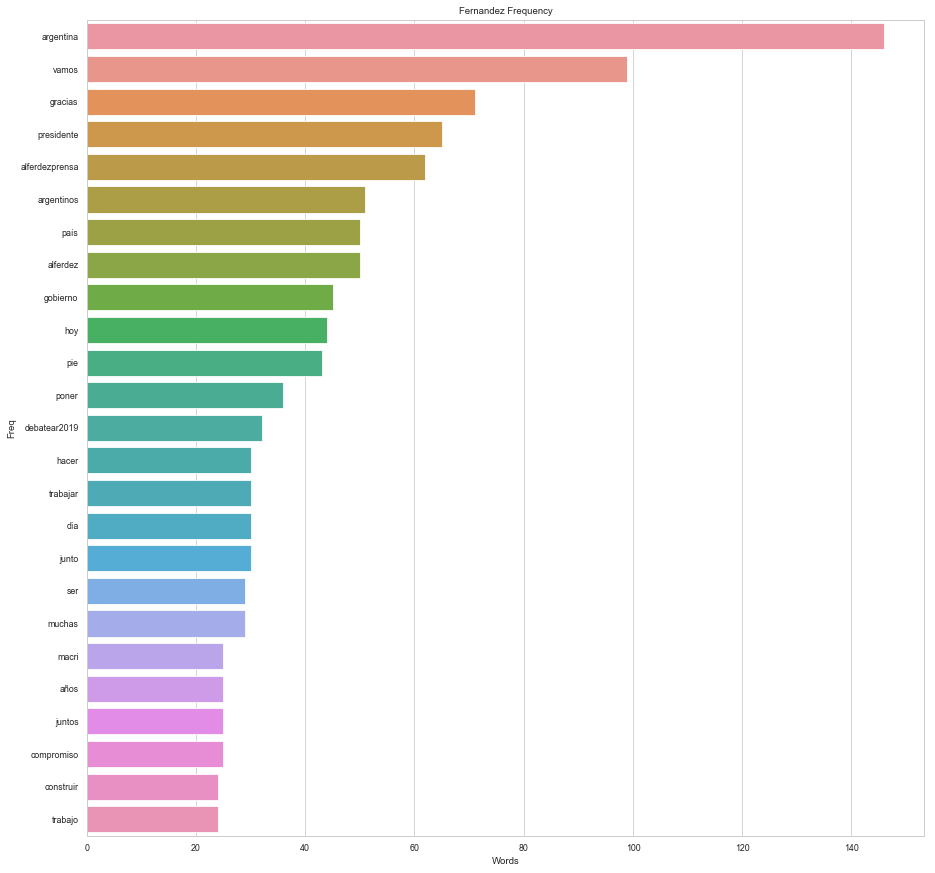

In [29]:
plt.figure(figsize=(15,15))
plt.title('Fernandez Frequency')
sns.barplot(x=AF['Freq'],y=AF['Term'])
plt.xlabel('Words')
plt.ylabel('Freq')
plt.show()

# Peronism vs Pro WordClouds

## Peronism

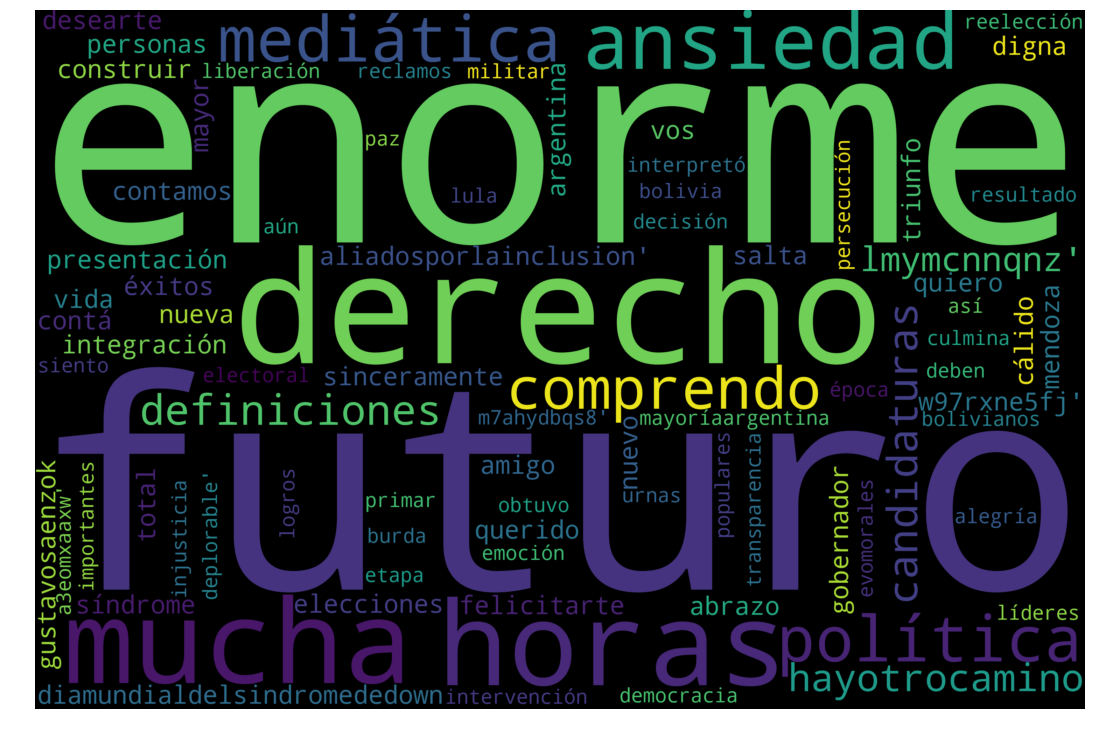

In [32]:
plt.figure(figsize=(15,10))
PERO = df.loc[df['corriente']=='peronista','tw'].apply(lambda x: ' '.join(x)).values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(PERO))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Pro

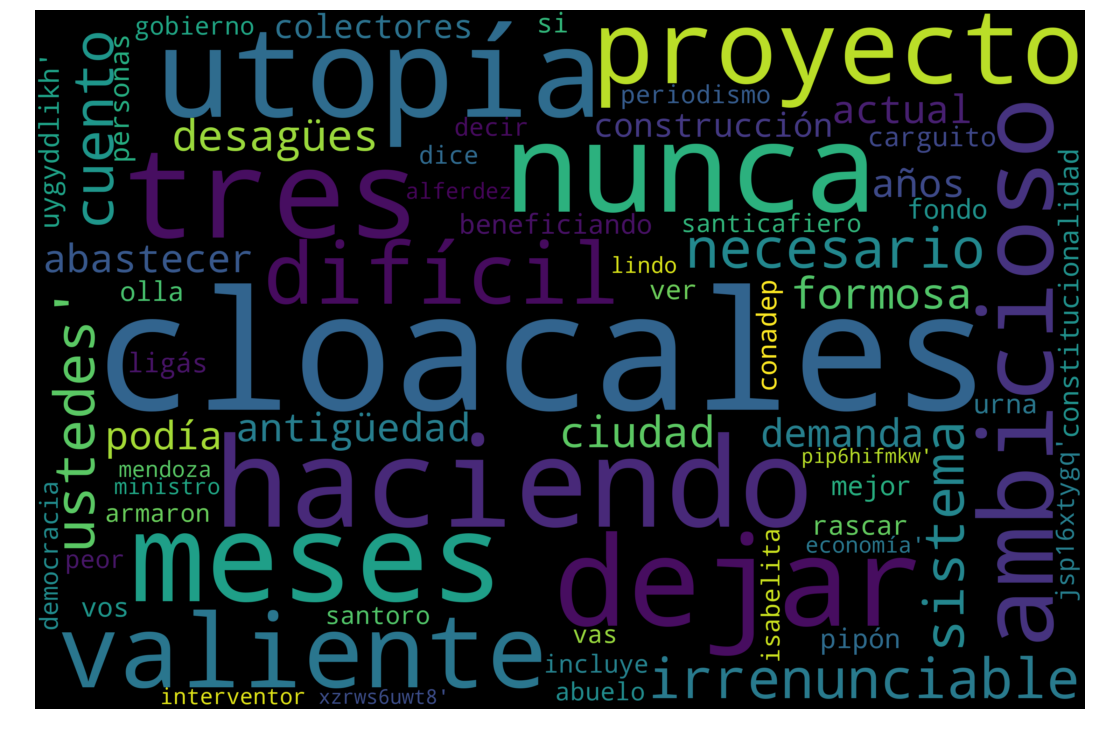

In [34]:
plt.figure(figsize=(15,10))
PRO = df.loc[df['corriente']=='pro','tw'].apply(lambda x: ' '.join(x)).values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(PRO))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Showing similarity between the accounts

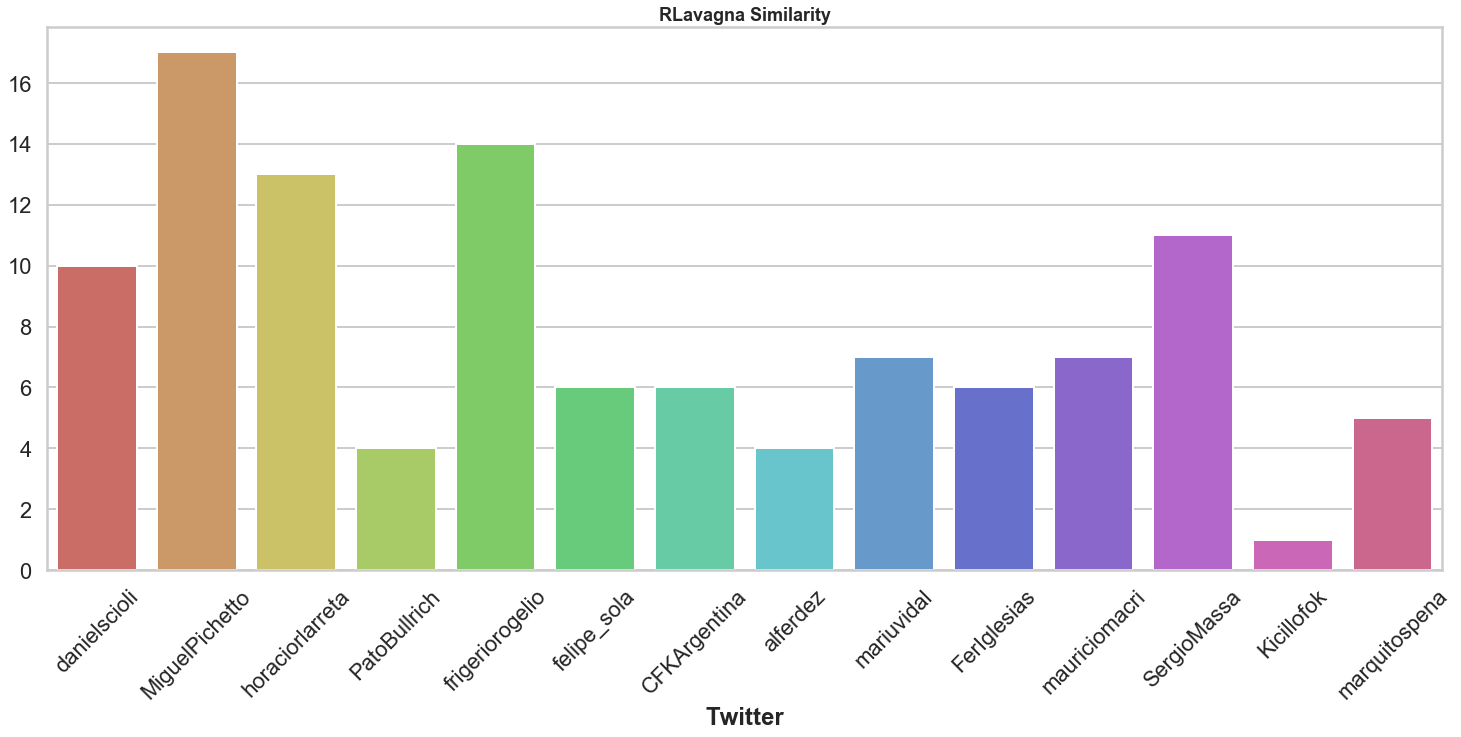

In [94]:
simil(df,'RLavagna',tol=0.30)

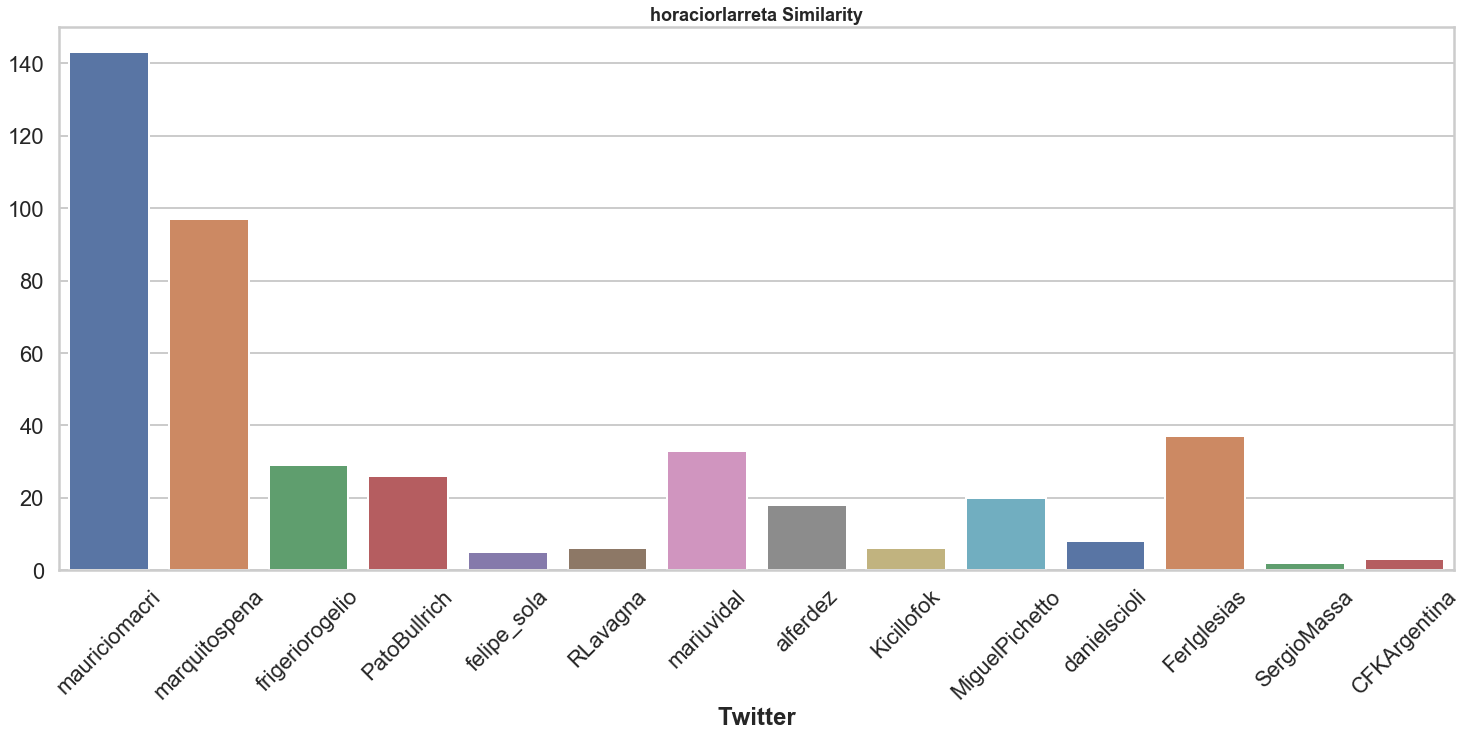

In [95]:
simil(df,'horaciorlarreta',tol=0.30)

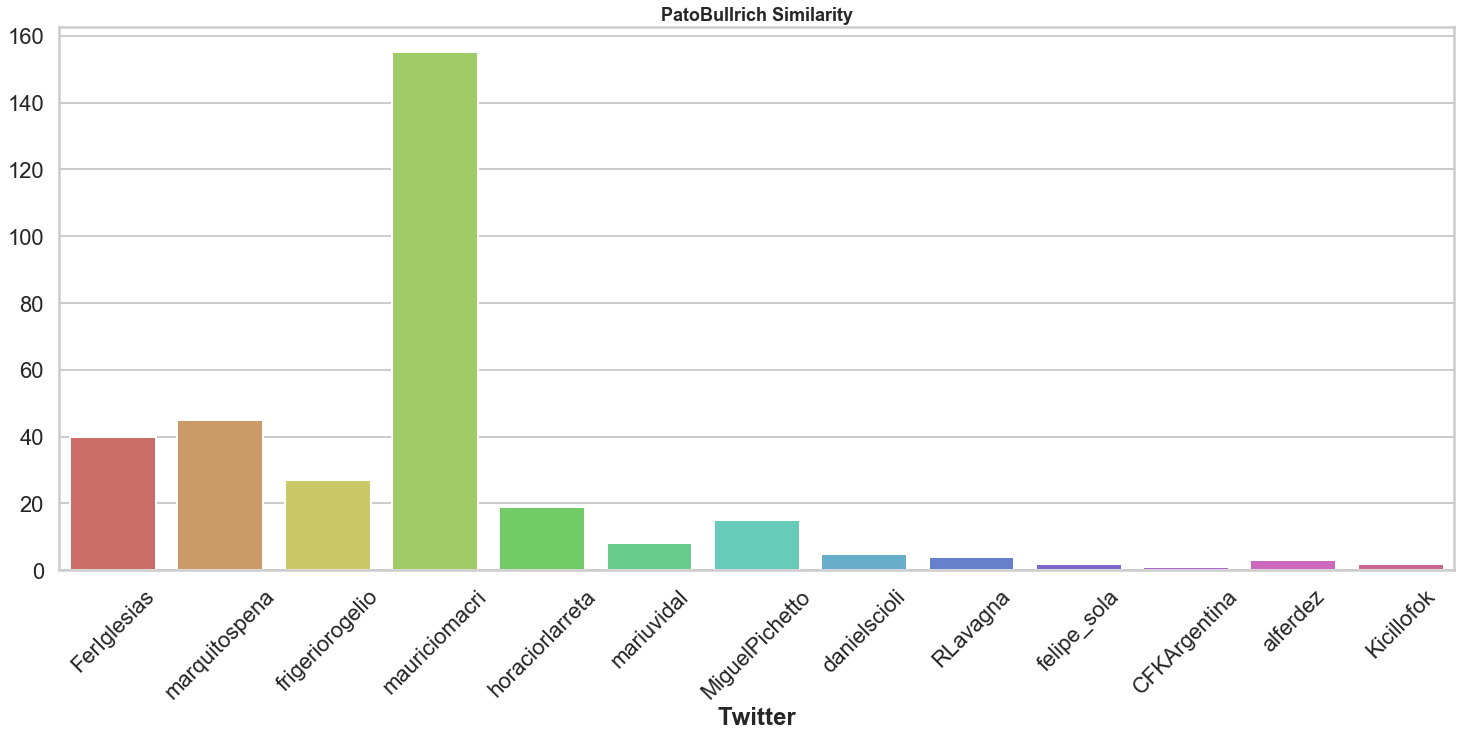

In [96]:
simil(df,'PatoBullrich',tol=0.30)

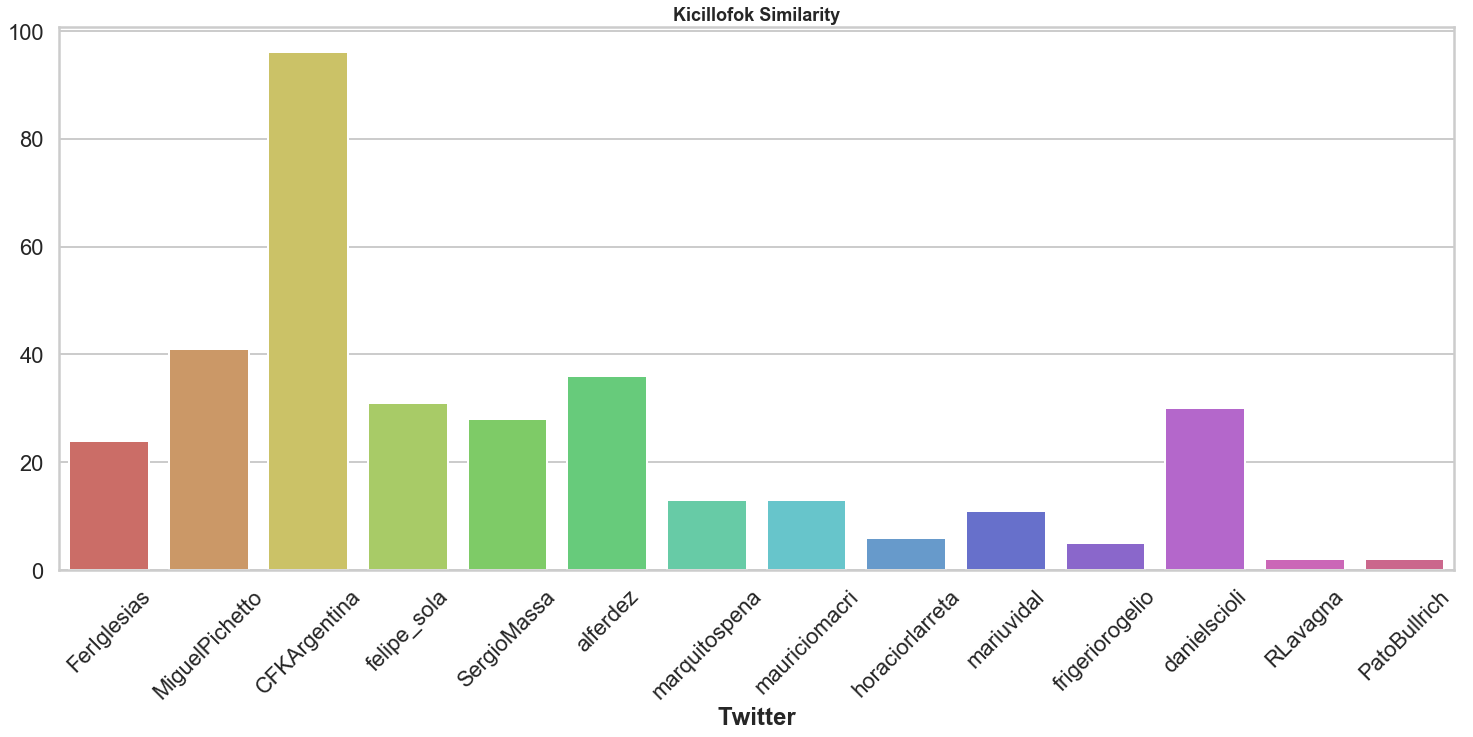

In [97]:
simil(df,'Kicillofok',tol=0.30)

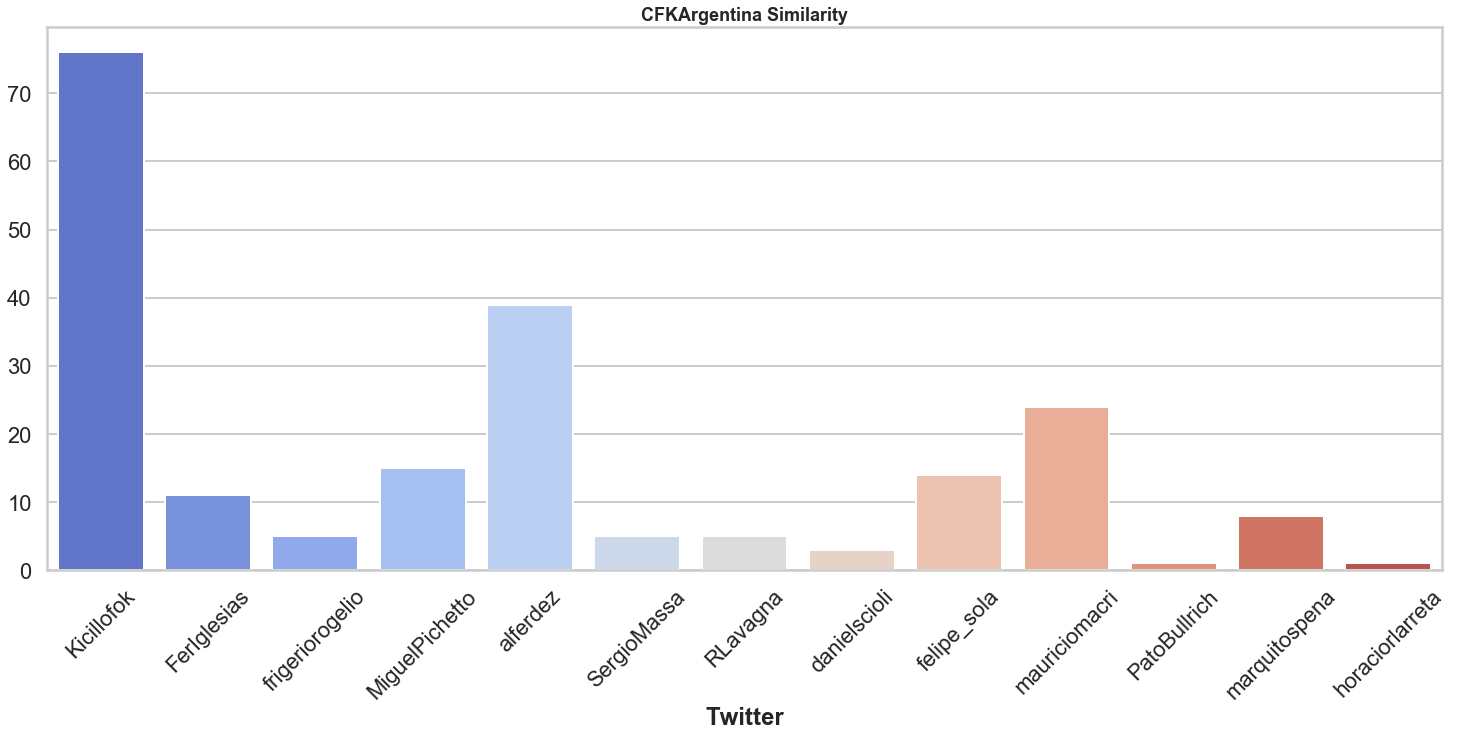

In [98]:
simil(df,'CFKArgentina',tol=0.30)

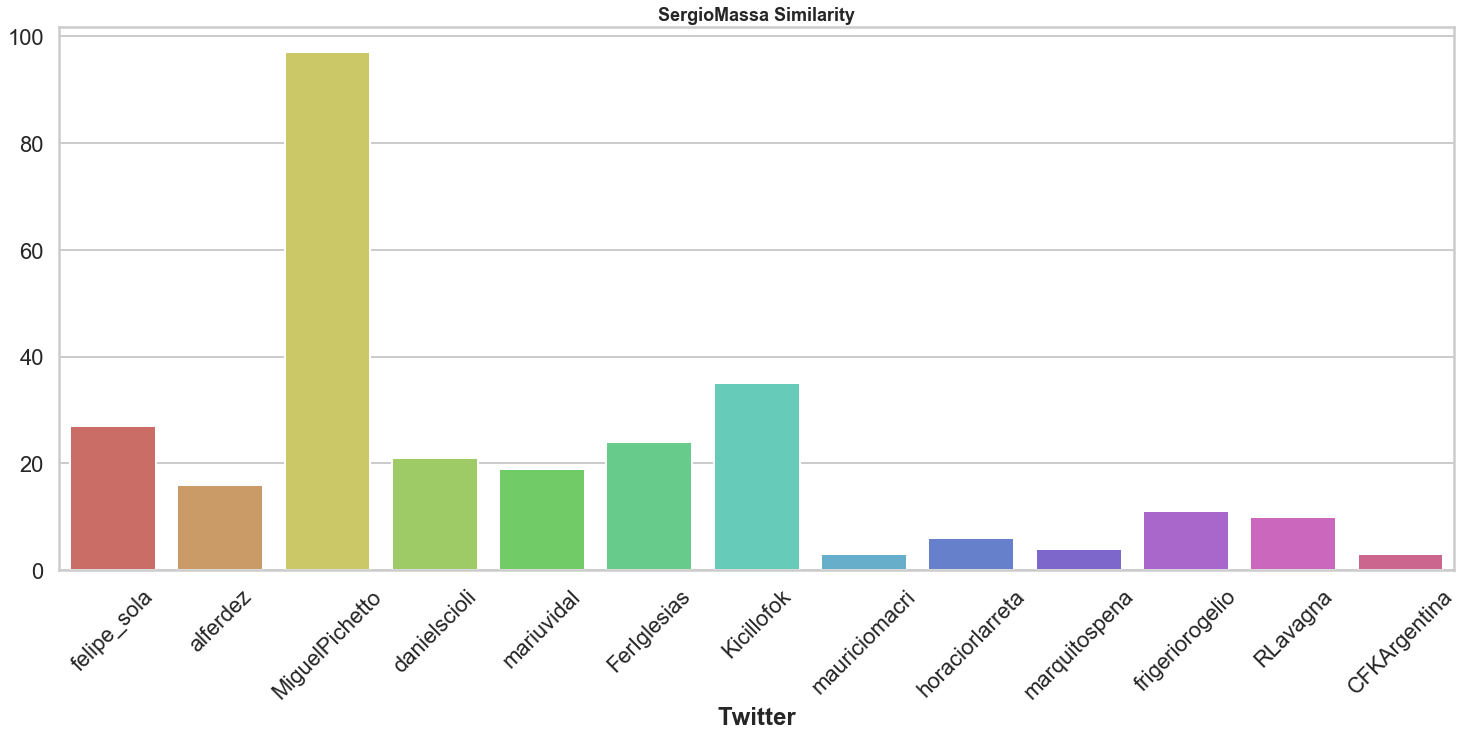

In [99]:
simil(df,'SergioMassa',tol=0.30)

# Classifier

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

Vectorization and Model selection

In [84]:
cv = CountVectorizer(stop_words=badwords)
vec = TfidfTransformer()
clf1 = SVC()
clf2 = GaussianNB()
clf3= RandomForestClassifier()

In [85]:
X = df['tweets']
y = df['target']

In [86]:
pipelines = []
pipelines.append(('vectSVM',Pipeline([('Count',cv),('Vect',vec),('SVM',clf1)])))
pipelines.append(('vectBayes',Pipeline([('Count',cv),('Vect',vec),('NB',clf3)])))
pipelines.append(('RandomForest',Pipeline([('Count',cv),('Vect',vec),('RF',clf3)])))

In [88]:
for name,model in pipelines:
    score = cross_val_score(model,X,y,scoring='accuracy',cv=10).mean().round(4)
    print(f'{name}: {score}')
    
   

vectSVM: 0.6487
vectBayes: 0.8236
RandomForest: 0.8273


Hyper-parameter tunning

In [123]:
RandomF = Pipeline([('Count',cv),('Vect',vec),('RF',RandomForestClassifier())])

In [124]:
param_grid = {'RF__n_estimators':[200,250,300]}

In [125]:
grid = GridSearchCV(RandomF,param_grid,scoring='accuracy',cv=10,n_jobs=-1,verbose=3)

In [126]:
grid.fit(X,y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['de', 'la...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'RF__n_estimators': [200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [127]:
grid.best_score_

0.8660397718513951

In [128]:
grid.best_params_

{'RF__n_estimators': 250}

In [129]:
RandomF = grid.estimator

In [130]:
RandomF.fit(X,y)

Pipeline(memory=None,
     steps=[('Count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['de', 'la...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Finaly we apply our model to the data set in order to have and estimation of how much peronist or pro is each tweet

In [138]:
df['Peroproba']=RandomF.predict_proba(df['tweets'])[:,0]
df['Proproba']=RandomF.predict_proba(df['tweets'])[:,1]

In [139]:
df.head(5)

,tweets,fecha,twitter,corriente,tw,tws,target,Peroproba,Proproba
0,sé que por estas horas hay mucha ansiedad polí...,2019-05-23 22:15:03,danielscioli,peronista,"[horas, mucha, ansiedad, política, mediática, ...",horas mucha ansiedad política mediática compre...,0,0.8,0.2
1,#diamundialdelsindromededown\r\r\r\r\r\r\r\r\r...,2019-03-21 20:37:21,RLavagna,peronista,"[diamundialdelsindromededown, derechos, vida, ...",diamundialdelsindromededown derechos vida dign...,0,0.8,0.2
2,"esto no es una utopía, es lo que estamos hacie...",2019-07-13 15:49:05,mariuvidal,pro,"[utopía, haciendo, tres, meses, dejar, nunca, ...",utopía haciendo tres meses dejar nunca proyect...,1,0.3,0.7
3,el sistema de desagües cloacales de la ciudad ...,2019-08-21 11:41:01,frigeriorogelio,pro,"[sistema, desagües, cloacales, ciudad, formosa...",sistema desagües cloacales ciudad formosa anti...,1,0.1,0.9
4,mejor rascar la urna que el fondo de la olla p...,2019-09-15 01:37:09,FerIglesias,pro,"[mejor, rascar, urna, fondo, olla, ver, si, li...",mejor rascar urna fondo olla ver si ligás carg...,1,0.0,1.0


In [140]:
peronista = df.loc[df['corriente']=='peronista']
pro = df.loc[df['corriente']=='pro']

In [141]:
peronista.sort_values(by='Proproba',ascending=False).head(1)['tweets']#the mosts Pro tweet from Peronis

6110    agradecería que marcos peña deje de gastar los...
Name: tweets, dtype: object

In [142]:
pro.sort_values(by='Peroproba',ascending=False).head(2)['tweets']#the mosts Peronist tweet from Pro

4479    bajate del vento que te vieron, cachafaz. \r\r...
1437    a partir de las 22 hs voy a estar junto a @die...
Name: tweets, dtype: object

Out of sample testing

In [161]:
df_test = pd.read_csv(r'test.csv',parse_dates=['fecha'])

In [162]:
df_test.set_index('fecha',inplace=True)

In [163]:
df=df_test.loc['2019-11-14':'2019-11-16'].reset_index()

In [164]:
wt = RegexpTokenizer('[\w]+')
df['tweets'] =df['tweets'].apply(lambda x: x.lower())
df['tw'] = df['tweets'].apply(lambda x: wt.tokenize(x))
badwords=stopwords.words('spanish')
morebw = ['https','t','co','En','vivo','rt','sé']
for x in morebw:
    badwords.append(x)
df['tw'] = df['tw'].apply(lambda x: [word for word in x if word not in badwords])
df['tws']=df['tw'].apply(lambda x: ' '.join(x))
df['target'] = df['corriente'].map({'peronista':0,'pro':1})
df=df.drop_duplicates('tws').reset_index(drop=True)

In [166]:
df.head()

,fecha,tweets,twitter,corriente,tw,tws,target
0,2019-11-14 00:49:13,hoy también recibí la visita de la presidenta ...,alferdez,peronista,"[hoy, recibí, visita, presidenta, banco, santa...",hoy recibí visita presidenta banco santander a...,0
1,2019-11-15 19:49:39,mi primer compromiso como presidente será unir...,alferdez,peronista,"[primer, compromiso, presidente, unir, volunta...",primer compromiso presidente unir voluntad arg...,0
2,2019-11-14 12:42:54,gracias al trabajo y la valentía de la @polici...,horaciorlarreta,pro,"[gracias, trabajo, valentía, policia_ciudad, d...",gracias trabajo valentía policia_ciudad detuvi...,1
3,2019-11-14 02:49:06,seeeeeeee!!! dale gasssss! https://t.co/a5yzbt...,FerIglesias,pro,"[seeeeeeee, dale, gasssss, a5yzbt61n5]",seeeeeeee dale gasssss a5yzbt61n5,1
4,2019-11-14 01:32:27,rt @democracy_intl: 📎 today at the canadian mi...,FerIglesias,pro,"[democracy_intl, today, at, the, canadian, mis...",democracy_intl today at the canadian mission t...,1


In [167]:
X = df['tweets']
y = df['target']

In [169]:
y_pred = RandomF.predict(X)

In [173]:
print(accuracy_score(y,y_pred))
print(confusion_matrix(y,y_pred))

0.813953488372093
[[ 8 13]
 [11 97]]


In [174]:
df['Peroproba']=RandomF.predict_proba(df['tweets'])[:,0]
df['Proproba']=RandomF.predict_proba(df['tweets'])[:,1]

In [175]:
df

,fecha,tweets,twitter,corriente,tw,tws,target,Peroproba,Proproba
0,2019-11-14 00:49:13,hoy también recibí la visita de la presidenta ...,alferdez,peronista,"[hoy, recibí, visita, presidenta, banco, santa...",hoy recibí visita presidenta banco santander a...,0,0.2,0.8
1,2019-11-15 19:49:39,mi primer compromiso como presidente será unir...,alferdez,peronista,"[primer, compromiso, presidente, unir, volunta...",primer compromiso presidente unir voluntad arg...,0,0.4,0.6
2,2019-11-14 12:42:54,gracias al trabajo y la valentía de la @polici...,horaciorlarreta,pro,"[gracias, trabajo, valentía, policia_ciudad, d...",gracias trabajo valentía policia_ciudad detuvi...,1,0.2,0.8
3,2019-11-14 02:49:06,seeeeeeee!!! dale gasssss! https://t.co/a5yzbt...,FerIglesias,pro,"[seeeeeeee, dale, gasssss, a5yzbt61n5]",seeeeeeee dale gasssss a5yzbt61n5,1,0.1,0.9
4,2019-11-14 01:32:27,rt @democracy_intl: 📎 today at the canadian mi...,FerIglesias,pro,"[democracy_intl, today, at, the, canadian, mis...",democracy_intl today at the canadian mission t...,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...
124,2019-11-14 01:43:37,rt @juancampanella: esto recién empieza. rt ht...,FerIglesias,pro,"[juancampanella, recién, empieza, fn7rrrb8pw]",juancampanella recién empieza fn7rrrb8pw,1,0.0,1.0
125,2019-11-15 13:58:08,"""tu poco instruida cabecita de profe de educac...",FerIglesias,pro,"[instruida, cabecita, profe, educación, física...",instruida cabecita profe educación física mand...,1,0.1,0.9
126,2019-11-14 00:18:39,tuve un excelente encuentro con los embajadore...,alferdez,peronista,"[excelente, encuentro, embajadores, unión, eur...",excelente encuentro embajadores unión europea ...,0,0.6,0.4
127,2019-11-15 13:11:20,en la reunión de conocimiento público que tuve...,RLavagna,peronista,"[reunión, conocimiento, público, hace, 15, día...",reunión conocimiento público hace 15 días pres...,0,0.4,0.6


In [176]:
pickle_out = open('Modelclf.pickle','wb')
pickle.dump(RandomF,pickle_out)
pickle_out.close()